# Create a catalog order

- <a href="#step-1">Step 1. Set up the notebook</a>
- <a href="#step-2">Step 2. Get access</a>
- <a href="#step-3">Step 3. Find and preview data</a>
- <a href="#step-4">Step 4. Create an order</a>
- <a href="#step-5">Step 5. Monitor orders</a>
- <a href="#step-6">Step 6. Download assets</a>

## <a id="step-1"></a> Step 1. Set up the notebook

### 1. Install prerequisites

In [1]:
!pip install up42-py --upgrade -q

import up42, rasterio, geojson
import pandas as pd


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### 2. Authenticate

Use your credentials to authenticate.

In [2]:
# Create a configuration file and use the following code for it:
# {
#   "username": "<your-email-address>",
#   "password": "<your-password>"
# }

up42.authenticate(cfg_file="/Users/max.mustermann/.up42/credentials.json")

2025-05-19 14:52:43,821 - Authentication with UP42 successful!


## <a id="step-2"></a> Step 2. Get access

### 1. Select a catalog collection

You can browse all archive collections in our glossary

In [15]:
archive_collections = up42.CollectionType.ARCHIVE
sort_by_name = up42.CollectionSorting.name
data_collections = up42.ProductGlossary.get_collections(
    collection_type=archive_collections, 
    sort_by=sort_by_name
)
pd.DataFrame({"collection": c.name, "product": d.name} for c in data_collections for d in c.data_products)

,collection,product
0,beijing-3a,beijing-3a-level-2-8bit
1,beijing-3a,beijing-3a-level-2-16bit
2,beijing-3a,beijing-3a-level-1-16bit
3,beijing-3a,beijing-3a-level-1-8bit
4,beijing-3n,beijing-3n-level-2-8bit
5,beijing-3n,beijing-3n-level-2-16bit
6,beijing-3n,beijing-3n-level-1-8bit
7,beijing-3n,beijing-3n-level-1-16bit
8,capella-gec,capella-gec-full-scene
9,capella-geo,capella-geo-full-scene


Choose a data product and the host to search for scenes.

In [4]:
# The sample uses Pléiades catalog — Analytic
data_collections = up42.ProductGlossary.get_collections(collection_type=archive_collections, sort_by=sort_by_name)
collection = next(c for c in data_collections if c.name == "phr")
data_product = next(d for d in collection.data_products if d.name.endswith("analytic"))
host = next(p for p in collection.providers if p.is_host)
collection.name, data_product.name, data_product.id, host.title

('phr', 'phr-analytic', '4f1b2f62-98df-4c74-81f4-5dce45deee99', 'OneAtlas')

### 2. Request access

If you want to order the chosen collection for the first time, you need to [request access to it](https://docs.up42.com/getting-started/restrictions#request-access).

An email from the Customer Success team usually takes up to 3 days. You can review your access request status on the [Access requests](https://console.up42.com/settings/access) page.

### 3. Accept the EULA

If you want to order the chosen collection for the first time, you need to accept its [end-user license agreement (EULA)](https://docs.up42.com/getting-started/account/eulas).

## <a id="step-3"></a> Step 3. Find and preview data

### 1. Search the catalog

Search the host to find a full scene that fits your requirements.

In [5]:
geometry = {
    "type":"Polygon",
    "coordinates":[[
        [13.369713, 52.452327],
        [13.369713, 52.470760],
        [13.339159, 52.470760],
        [13.339159, 52.452327],
        [13.369713, 52.452327]
    ]]
}

scenes = list(host.search(
    collections=[collection.name],
    intersects=geometry,
    start_date="2022-06-01",
    end_date="2022-12-31",
    query={
        "cloudCoverage": {"LT": 20}
    }
))

Output a dataframe with full scenes that match the specified parameters.

In [6]:
pd.DataFrame(scenes)
# scenes # Uncomment to output data class instances instead

,bbox,geometry,id,datetime,start_datetime,end_datetime,constellation,collection,cloud_coverage,resolution,delivery_time,producer,quicklook
0,"[13.33915989329133, 52.45232754184865, 13.6447...","{'type': 'Polygon', 'coordinates': [[[13.51834...",ea42904d-d1ef-4b4f-824b-164a0edfecc1,2022-10-26T10:23:47Z,None,None,phr,phr,4.8,0.5,DAYS,airbus,{'url': 'https://api.up42.com/catalog/oneatlas...
1,"[13.08523276731513, 52.45065923655355, 13.3995...","{'type': 'Polygon', 'coordinates': [[[13.37707...",52d0b74e-492c-4f6c-ac51-e40dffb63273,2022-10-26T10:23:35Z,None,None,phr,phr,5.5,0.5,DAYS,airbus,{'url': 'https://api.up42.com/catalog/oneatlas...
2,"[13.09330243482808, 52.29227641565387, 13.3914...","{'type': 'Polygon', 'coordinates': [[[13.26824...",d3231673-9246-4659-9123-a9671d425d7c,2022-10-20T10:20:09Z,None,None,phr,phr,17.8,0.5,DAYS,airbus,{'url': 'https://api.up42.com/catalog/oneatlas...
3,"[13.34039801332115, 52.28960854936309, 13.6438...","{'type': 'Polygon', 'coordinates': [[[13.64386...",6f15e47c-2ec8-431c-bbb6-3748e5f1be0b,2022-10-20T10:19:54Z,None,None,phr,phr,9.1,0.5,DAYS,airbus,{'url': 'https://api.up42.com/catalog/oneatlas...


### 2. Preview data

Some data hosts provide free, low-resolution quicklooks that you can preview before creating an order. Note that some quicklooks may not fully match the scene they represent.
You can visualize the quicklook using Jupyter display components

539it [00:00, 15380.68it/s]
2025-05-19 15:20:00,524 - Successfully downloaded the file at quicklooks/quicklook_ea42904d-d1ef-4b4f-824b-164a0edfecc1.jpg


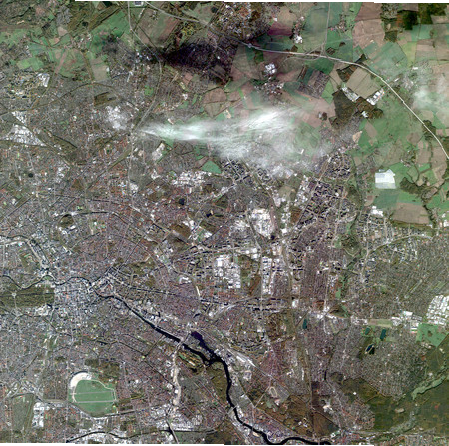

In [21]:
from IPython.display import Image
# Download quicklook to quicklooks directory
scene = scenes[0]
quicklook_path = scene.quicklook.download("./quicklooks/")
Image(quicklook_path)

Since the quicklook image is not georeferenced, you might need to georeference it. 

In [ ]:
import shapely as shp
# Define a function to georeference quicklook
def georeference(
    src_path: str, dst_path: str, bounds: tuple[float, float, float, float]
):
    with rasterio.open(src_path) as src:
        data = src.read()
        transform = rasterio.transform.from_bounds(
            *bounds, data.shape[2], data.shape[1]
        )

        with rasterio.open(
            dst_path,
            "w",
            driver=src.driver,
            height=src.height,
            width=src.width,
            count=src.count,
            dtype=src.dtypes[0],
            crs="EPSG:4326",
            transform=transform,
        ) as dst:
            dst.write(data)
# Georefence the quicklooks
out_path = f"./quicklooks/georeferenced_quicklook_{scene.id}.png"
georeference(
    quicklook_path,
    out_path,
    shp.geometry.shape(scene.geometry).bounds,    
)

Open the `quicklooks` folder. You will find the following files added by the cell above:

- The original quicklook
- A metadata file needed for georeferencing
- The georeferenced quicklook with the `georeferenced` prefix

[Visualize](https://docs.up42.com/help/visualize) the georeferenced quicklook in a third-party GIS software.

## <a id="step-4"></a> Step 4. Create an order

### 1. Fill out an order form

Get detailed information about the parameters needed to create an order for the chosen data product.

In [8]:
data_product.schema

{'additionalProperties': False,
 'properties': {'id': {'title': 'Id', 'type': 'string'},
  'aoi': {'$ref': '#/definitions/Polygon'}},
 'required': ['id', 'aoi'],
 'title': 'ParamsWithAOI',
 'type': 'object',
 '$schema': 'https://json-schema.org/draft-07/schema',
 'definitions': {'Polygon': {'description': 'Polygon Model.',
   'properties': {'type': {'const': 'Polygon',
     'default': 'Polygon',
     'enum': ['Polygon'],
     'title': 'Type',
     'type': 'string'},
    'coordinates': {'items': {'items': {'items': {'type': 'number'},
       'maxItems': 2,
       'minItems': 2,
       'type': 'array'},
      'minItems': 4,
      'type': 'array'},
     'type': 'array'}},
   'required': ['coordinates'],
   'title': 'Polygon',
   'type': 'object'}}}

Use the required request body schema format for the chosen data product.

In [9]:
from datetime import date
features = geojson.FeatureCollection(features=[geojson.Feature(geometry=geometry)])
order_template = up42.BatchOrderTemplate(
    data_product_id=data_product.id,
    display_name=f"{data_product.name}-{date.today()}",
    features=features,
    params={
        "id": scene.id
    },
    tags=["sdk", data_product.name]
)


### 2. Get a cost estimate

Get a cost estimate before placing the order.

In [11]:
order_template.estimate

Estimate(items=[OrderCost(index=0, credits=3870, size=3.87, unit='SQ_KM')], credits=3870, size=3.87, unit='SQ_KM')

The response returns the overall credit amount that will be deducted from your credit balance if you decide to proceed with the ordering.

### 3. Create an order

Place the order using the template.

Credits will be deducted upon successful completion of the created catalog order. The transaction can't be reversed.

In [12]:
# order = order_template.place()
# order

## <a id="step-5"></a> Step 5. Monitor orders

Check the [status](https://docs.up42.com/developers/api-catalog#order-statuses) of your order. To learn about the timeframe of catalog orders, see [Asset delivery time](https://docs.up42.com/data/archive/delivery).

In [13]:
# order.status

You can also track the order status until the order is completed.

In [14]:
# order.track_status()

## <a id="step-6"></a> Step 6. Download assets

The following statuses mean you can download assets from storage:
- `BEING_FULFILLED`: Some order assets might have been delivered. [Download](https://github.com/up42/documentation-notebooks/blob/main/storage/sdk-storage-assets.ipynb) these assets using the `Storage` class.
- `FULFILLED`: All order assets have been delivered. [Download](https://github.com/up42/documentation-notebooks/blob/main/storage/sdk-order-assets.ipynb) these assets using the `Order` class.